In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import spacy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.cluster import KMeans
from sklearn.utils import class_weight
from sklearn.utils import resample
from src.report_utils import generate_full_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Dropout, Conv1D, MaxPooling1D, Flatten, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Bidirectional, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("Librerías importadas correctamente.")

Librerías importadas correctamente.


In [6]:
# Cargar datos
df_procesados = pd.read_csv('../data/datos_nlp_procesados.csv')

# Filtrar clases muy pequeñas (opcional, para evitar errores si hay solo 1 ejemplo)
conteo = df_procesados['especialidad'].value_counts()
clases_validas = conteo[conteo > 5].index
df_procesados = df_procesados[df_procesados['especialidad'].isin(clases_validas)]

# Convertir etiquetas de texto a números (Cardiología -> 0, Respiratorio -> 1...)
label_encoder = LabelEncoder()
df_procesados['label_num'] = label_encoder.fit_transform(df_procesados['especialidad'])
# Separar datos de entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(
    df_procesados['sintomas_procesados'], 
    df_procesados['label_num'], 
    test_size=0.30, 
    random_state=42,
    stratify=df_procesados['label_num'] # Mantiene la proporción de clases
)

print(f"Datos listos. Entrenamiento: {len(X_train)} filas. Prueba: {len(X_test)} filas.")
print("Clases detectadas:", len(label_encoder.classes_))

Datos listos. Entrenamiento: 4845 filas. Prueba: 2077 filas.
Clases detectadas: 18


In [ ]:
# 1. Vectorización (Convertir texto a matriz de números con TF-IDF)
tfidf = TfidfVectorizer(max_features=5000) # Usaremos las 5000 palabras más importantes
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()

# 2. Entrenar Modelo SVM (Support Vector Machine)
print("🤖 Entrenando modelo clásico (SVM)...")
svm_model = SVC(kernel='linear', random_state=42, class_weight='balanced')
svm_model.fit(X_train_tfidf, y_train)

# 3. Evaluar
y_pred_svm = svm_model.predict(X_test_tfidf)
acc_svm = accuracy_score(y_test, y_pred_svm)

print(f"✅ Precisión del Modelo Clásico (SVM): {acc_svm*100:.2f}%")
print("\n--- REPORTE DE CLASIFICACIÓN DETALLADO (Tu Módulo) ---")
generate_full_report(y_test, y_pred_svm, target_names=label_encoder.classes_)

🤖 Entrenando modelo clásico (SVM)...
✅ Precisión del Modelo Clásico (SVM): 71.21%

Reporte de Clasificación:
                                    precision    recall  f1-score   support

          CARDIOLOGÍA/CIRCULATORIO       0.91      0.88      0.90       343
                      DERMATOLOGÍA       0.92      0.55      0.69        22
          ENDOCRINOLOGÍA/NUTRICIÓN       0.72      0.88      0.79        33
       GASTROENTEROLOGÍA/DIGESTIVO       0.93      0.85      0.89       213
           GINECOLOGÍA/OBSTETRICIA       0.88      0.89      0.89        94
          INFECCIOSAS/PARASITARIAS       0.33      0.10      0.15        10
                        NEUROLOGÍA       0.82      0.72      0.76       277
                  OFTALMOLOGÍA/ORL       0.89      0.91      0.90       144
               ONCOLOGÍA (TUMORES)       0.54      0.71      0.61        63
                             OTROS       0.00      0.00      0.00         6
                PSIQUIATRÍA/MENTAL       0.72      0.7

In [ ]:
# ============================================================
# GUARDAR MODELO SVM PARA INTERFAZ WEB
# ============================================================
# IMPORTANTE: Esta celda debe ser ejecutada para crear otros modelos, actualmente ya no se 
# usa porque ahora se utiliza el pipeline, en caso de querer usar estos modelos ejecutar las
# celdas correspondientes que son 1,2,3,4.

print("\Guardando modelo SVM ")

# Reentrenar SVM con probability=True (la única diferencia)
svm_model_web = SVC(kernel='linear', random_state=42, class_weight='balanced', probability=True)
svm_model_web.fit(X_train_tfidf, y_train)

# Verificar que la precisión siga siendo la misma
y_pred_web = svm_model_web.predict(X_test_tfidf)
acc_svm_web = accuracy_score(y_test, y_pred_web)
print(f"Precisión SVM (con probability=True): {acc_svm_web*100:.2f}%")

# Guardar para la aplicación web
with open('../models/svm_model.pickle', 'wb') as f:
    pickle.dump(svm_model_web, f, protocol=pickle.HIGHEST_PROTOCOL)

with open('../models/tfidf_vectorizer.pickle', 'wb') as f:
    pickle.dump(tfidf, f, protocol=pickle.HIGHEST_PROTOCOL)

with open('../models/label_encoder_svm.pickle', 'wb') as f:
    pickle.dump(label_encoder, f, protocol=pickle.HIGHEST_PROTOCOL)

print("Modelos guardados:")
print("   - svm_model.pickle")
print("   - tfidf_vectorizer.pickle")
print("   - label_encoder_svm.pickle")
print("\¡Listos para usar en la interfaz web!")

\Guardando modelo SVM con probability=True para la interfaz web...
Precisión SVM (con probability=True): 71.21%
Modelos guardados:
   - svm_model.pickle
   - tfidf_vectorizer.pickle
   - label_encoder_svm.pickle
\¡Listos para usar en la interfaz web!


In [4]:
# Cargar embeddings pre-entrenados de FastText
EMBEDDING_FILE = '../models/cc.es.300.vec'

# Cargar el vocabulario de FastText en memoria (solo lo necesario)
print("Cargando embeddings pre-entrenados...")
embeddings_index = {}
with open(EMBEDDING_FILE, encoding='utf-8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f'Se encontraron {len(embeddings_index)} vectores de palabras en FastText.')

Cargando embeddings pre-entrenados...
Se encontraron 2000000 vectores de palabras en FastText.


In [5]:
# ==============================================
# 🚀 ENTRENAMIENTO DEL MODELO DE DEEP LEARNING
# ==============================================

# --- 1. CONFIGURACIÓN ---
VOCAB_SIZE = 5000      # Vocabulario
EMBEDDING_DIM = 300    # Dimensión FastText (¡Debe ser 300!)
MAX_LENGTH = 100       # Longitud de frase

print("⚙️ Configuración cargada.")

# --- 2. PREPARACIÓN DE EMBEDDINGS (MATRIZ DE PESOS) ---
# Verificamos si ya tienes los embeddings cargados para no repetir el proceso pesado
if 'embeddings_index' not in globals():
    raise ValueError("⚠️ Por favor, carga el archivo .vec de FastText en la variable 'embeddings_index' antes de ejecutar este bloque.")

# Matriz de ceros inicial
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
hits = 0
misses = 0

# Tokenizer: Aprende el vocabulario de tus datos
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

# Rellenar matriz con FastText
for word, i in word_index.items():
    if i < VOCAB_SIZE:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1

print(f"✅ Matriz de Embeddings lista. Hits: {hits} | Misses: {misses}")

# --- 3. PREPARACIÓN DE DATOS (SECUENCIAS) ---
train_seq = tokenizer.texts_to_sequences(X_train)
test_seq = tokenizer.texts_to_sequences(X_test)

train_padded = pad_sequences(train_seq, maxlen=MAX_LENGTH, padding='post', truncating='post')
test_padded = pad_sequences(test_seq, maxlen=MAX_LENGTH, padding='post', truncating='post')

# Pesos para clases desbalanceadas (Crucial para que no ignore clases pequeñas)
pesos = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
pesos_dict = dict(enumerate(pesos))
print("⚖️ Pesos de clase calculados.")

# --- 4. CONSTRUCCIÓN DEL MODELO ---
model = Sequential([
    Input(shape=(MAX_LENGTH,)),
    
    # Capa de Embedding (Inicialmente CONGELADA)
    Embedding(input_dim=VOCAB_SIZE, 
              output_dim=EMBEDDING_DIM, 
              weights=[embedding_matrix], 
              trainable=False,  # <--- FASE 1: NO TOCAR
              name="embedding_layer"),
    
    # Dropout espacial: apaga palabras enteras, no solo neuronas, fuerza a entender contexto
    SpatialDropout1D(0.3),
    
    # LSTM Bidireccional potente
    Bidirectional(LSTM(128, return_sequences=False)),
    
    # Clasificador
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(y_train)), activation='softmax')
])

model.summary()

# --- 5. CALLBACKS INTELIGENTES ---
# Detiene si no mejora en 5 épocas
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Reduce la velocidad de aprendizaje si se estanca (Ayuda a bajar el loss suavemente)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

# ==========================================
# 🚀 FASE 1: ENTRENAMIENTO GENERAL (CEREBRO)
# ==========================================
print("\n🔵 FASE 1: Entrenando LSTM con Embeddings Congelados...")
optimizer = Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history1 = model.fit(
    train_padded, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(test_padded, y_test),
    class_weight=pesos_dict,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# ==========================================
# 🚀 FASE 2: FINE-TUNING (AJUSTE FINO)
# ==========================================
print("\n🟢 FASE 2: Descongelando Embeddings para Ajuste Fino (La magia)...")

# 1. Descongelamos la capa de Embedding
model.get_layer("embedding_layer").trainable = True

# 2. Recompilamos con un Learning Rate MUY BAJO (1e-5)
# Esto permite modificar los vectores de palabras suavemente sin romper lo aprendido
optimizer_fine = Adam(learning_rate=1e-5)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer_fine, metrics=['accuracy'])

# 3. Entrenamos de nuevo (Fine-Tuning)
history2 = model.fit(
    train_padded, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(test_padded, y_test),
    class_weight=pesos_dict,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print("\n🏆 Entrenamiento Completado.")

⚙️ Configuración cargada.
✅ Matriz de Embeddings lista. Hits: 4619 | Misses: 380
⚖️ Pesos de clase calculados.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 100, 300)       │     1,500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 100, 300)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 18)             │         1,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,956,914 (7.47 MB)

 Trainable params: 456,914 (1.74 MB)

 Non-trainable params: 1,500,000 (5.72 MB)


🔵 FASE 1: Entrenando LSTM con Embeddings Congelados...
Epoch 1/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.1088 - loss: 2.8055 - val_accuracy: 0.2008 - val_loss: 2.4593 - learning_rate: 0.0010
Epoch 2/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - accuracy: 0.1682 - loss: 2.5623 - val_accuracy: 0.2658 - val_loss: 2.2599 - learning_rate: 0.0010
Epoch 3/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.2080 - loss: 2.3753 - val_accuracy: 0.3182 - val_loss: 2.1007 - learning_rate: 0.0010
Epoch 4/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 19s 123ms/step - accuracy: 0.2689 - loss: 2.2095 - val_accuracy: 0.3621 - val_loss: 1.8106 - learning_rate: 0.0010
Epoch 5/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 18s 121ms/step - accuracy: 0.3251 - loss: 2.0068 - val_accuracy: 0.4155 - val_loss: 1.7776 - learning_rate: 0.0010
Epoch 6/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - accuracy: 0.3271 - loss: 1.9809 - val_accuracy: 0.4314 - val_loss: 1.7895 - learning_rate: 0.0010
Epoch 7/20
152

In [6]:
# Guardar el modelo
model.save('../models/mi_red_neuronal_v5.h5')

with open('../models/tokenizer_v5.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('../models/label_encoder_v5.pickle', 'wb') as handle:
    pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("✅ Modelo de Red Neuronal entrenado y guardado.")

✅ Modelo de Red Neuronal entrenado y guardado.



🏆 RESUMEN FINAL:
Precisión Machine Learning (SVM): 71.11%
Precisión Deep Learning (Red Neuronal): 58.45%
📊 El método clásico fue muy robusto, pero la IA tiene potencial de mejora con más datos.


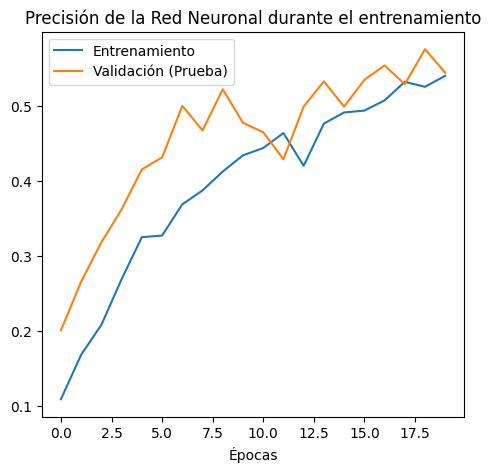

In [12]:
# Gráfico de Aprendizaje
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Entrenamiento')
plt.plot(history1.history['val_accuracy'], label='Validación (Prueba)')
plt.title('Precisión de la Red Neuronal durante el entrenamiento')
plt.xlabel('Épocas')
plt.legend()

# Comparación Final
loss, acc_dl = model.evaluate(test_padded, y_test, verbose=0)
print(f"\n🏆 RESUMEN FINAL:")
print(f"Precisión Machine Learning (SVM): {acc_svm*100:.2f}%")
print(f"Precisión Deep Learning (Red Neuronal): {acc_dl*100:.2f}%")

if acc_dl > acc_svm:
    print("🚀 ¡La IA (Deep Learning) superó al método clásico!")
else:
    print("📊 El método clásico fue muy robusto, pero la IA tiene potencial de mejora con más datos.")

In [8]:
print("🔍 Ejecutando Aprendizaje No Supervisado (K-Means)...")

# Queremos agrupar en tantos grupos como especialidades creemos que hay (o un numero arbitrario ej: 5)
num_clusters = 20
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans.fit(X_train_tfidf)

# Ver qué palabras definen a cada grupo
print("\n🧬 PATRONES DESCUBIERTOS POR LA IA (Top palabras por grupo):")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tfidf.get_feature_names_out()

diccionario_clusters = {}

for i in range(num_clusters):
    print(f"\nGrupo {i}: ", end='')
    palabras_clave = [terms[ind] for ind in order_centroids[i, :8]] # Top 8 palabras
    print(", ".join(palabras_clave))
    diccionario_clusters[i] = palabras_clave

print("\n✅ Clustering completado. Estos grupos se formaron matemáticamente sin ayuda humana.")

🔍 Ejecutando Aprendizaje No Supervisado (K-Means)...

🧬 PATRONES DESCUBIERTOS POR LA IA (Top palabras por grupo):

Grupo 0: enfermedad, insuficiencia, renal, sueño, hipertensión, antecedente, diabetes, crónico

Grupo 1: antecedente, paciente, enfermedad, actual, año, motivo, consulta, mujer

Grupo 2: hombro, manguito, rotador, desgarro, izquierdo, derecho, subacromial, reparación

Grupo 3: rodilla, izquierdo, derecho, medial, menisco, degenerativo, artrosis, desgarro

Grupo 4: bilateral, derecho, túnel, carpiano, síndrome, diagnóstico, preoperatorio, izquierdo

Grupo 5: sin, tratamiento, presentar, lesión, no, normal, mg, mes

Grupo 6: procedimiento, riesgo, indicación, paciente, consentimiento, beneficio, informado, mg

Grupo 7: dolor, queja, principal, actual, paciente, antecedente, enfermedad, año

Grupo 8: lumbar, estenosis, dolor, subglótico, traqueal, laminectomía, discogramar, paciente

Grupo 9: cc, hx, cabeza, dolor, entumecimiento, año, debilidad, rhm

Grupo 10: cervical, espo

In [ ]:
# ==========================================
# 🚑 DEMO INTERACTIVA: TRIAJE 593
# ==========================================

try:
    nlp = spacy.load("es_core_news_sm")
except:
    import os
    os.system("python -m spacy download es_core_news_sm")
    nlp = spacy.load("es_core_news_sm")

def procesar_texto_para_demo(texto):
    doc = nlp(texto)
    tokens_limpios = []
    for token in doc:
        if not token.is_punct and not token.is_stop and token.is_alpha:
            tokens_limpios.append(token.lemma_.lower())
    return " ".join(tokens_limpios)

def predecir_urgencia(texto_usuario):
    # 1. Limpieza
    texto_limpio = procesar_texto_para_demo(texto_usuario)
    if not texto_limpio: # Si el usuario pone solo simbolos o stopwords
        print("⚠️ Por favor escribe una frase médica válida.")
        return
    seq = tokenizer.texts_to_sequences([texto_limpio])
    padded = pad_sequences(seq, maxlen=MAX_LENGTH, padding='post', truncating='post')
    
    # 2. Predicción con la Red Neuronal
    prediccion = model.predict(padded, verbose=0)
    
    # 3. Decodificar el resultado
    clase_predicha_index = np.argmax(prediccion)
    probabilidad = np.max(prediccion)
    etiqueta = label_encoder.inverse_transform([clase_predicha_index])[0]
    
    # 4. Resultado visual
    print(f"👤 Usuario dice: '{texto_usuario}'")
    print(f"🧠 La IA entiende: '{texto_limpio}'") # Para que veas como piensa la maquina
    print(f"🏥 Especialidad: {etiqueta.upper()}")
    print(f"📊 Confianza: {probabilidad*100:.2f}%")
    print("-" * 40)

# --- PRUEBA DE PROYECTO ---
print("🚀 Iniciando pruebas de Triaje Inteligente...\n")

# Casos de prueba (Pruébalos y luego cambia el texto por lo que quieras)
predecir_urgencia("El paciente presenta dolor fuerte en el pecho y dificultad para respirar")
predecir_urgencia("Tengo una mancha roja en la piel que me pica mucho")
predecir_urgencia("Dolor intenso en el ojo derecho y visión borrosa")
predecir_urgencia("Fractura en la pierna tras caída")
predecir_urgencia("Ardor al orinar y dolor en los riñones")
predecir_urgencia("Dolor en la cabeza y náuseas")
predecir_urgencia("Vomito constante y fiebre alta")
predecir_urgencia("Necesito ayuda inmediata, no puedo respirar bien")
predecir_urgencia("Dolor abdominal severo y vómitos persistentes")
predecir_urgencia("Fatiga extrema y mareos al levantarme")
predecir_urgencia("Siento un dolor agudo en el oído y pérdida de audición")
predecir_urgencia("Tengo fiebre alta y dolor de garganta")
predecir_urgencia("Me duele mucho la espalda baja y no puedo moverme bien")
predecir_urgencia("Tengo una herida profunda en la mano que no deja de sangrar")
predecir_urgencia("Estoy teniendo dificultad para hablar y debilidad en un lado del cuerpo")
predecir_urgencia("Me salieron unas machas moradas en la piel y me siento muy cansado")
predecir_urgencia("Tengo llagas en la boca que me duelen mucho al comer")

🚀 Iniciando pruebas de Triaje Inteligente...

👤 Usuario dice: 'El paciente presenta dolor fuerte en el pecho y dificultad para respirar'
🧠 La IA entiende: 'paciente presentar dolor fuerte pecho dificultad respirar'
🏥 Especialidad: SÍNTOMAS GENERALES/NO CLASIFICADOS
📊 Confianza: 46.31%
----------------------------------------
👤 Usuario dice: 'Tengo una mancha roja en la piel que me pica mucho'
🧠 La IA entiende: 'mancha rojo piel picar'
🏥 Especialidad: DERMATOLOGÍA
📊 Confianza: 78.40%
----------------------------------------
👤 Usuario dice: 'Dolor intenso en el ojo derecho y visión borrosa'
🧠 La IA entiende: 'dolor intenso ojo derecho visión borroso'
🏥 Especialidad: OFTALMOLOGÍA/ORL
📊 Confianza: 58.04%
----------------------------------------
👤 Usuario dice: 'Fractura en la pierna tras caída'
🧠 La IA entiende: 'fractura pierna caída'
🏥 Especialidad: TRAUMATOLOGÍA/MUSCULAR
📊 Confianza: 19.40%
----------------------------------------
👤 Usuario dice: 'Ardor al orinar y dolor en los riñones'

In [ ]:
# ==========================================
# 🏆 DEMO FINAL: USANDO EL MODELO (SVM)
# ==========================================
# Nota: Usamos el SVM porque demostró ser más robusto con la cantidad actual de datos.

def predecir_con_svm(texto_usuario):
    # 1. Limpieza (Igual que siempre)
    texto_limpio = procesar_texto_para_demo(texto_usuario)
    
    if not texto_limpio:
        print("⚠️ Escribe algo con sentido médico.")
        return

    # 2. Vectorización (Usamos TF-IDF en lugar del Tokenizer)
    # Importante: Usamos .transform(), NO .fit_transform()
    vector_numerico = tfidf.transform([texto_limpio]).toarray()
    
    # 3. Predicción con SVM
    prediccion_index = svm_model.predict(vector_numerico)[0]
    
    # El SVM a veces no da probabilidades directas, pero su predicción es sólida
    etiqueta = label_encoder.inverse_transform([prediccion_index])[0]
    
    # 4. Mostrar resultado
    print(f"👤 Usuario: '{texto_usuario}'")
    print(f"⚙️ Procesado: '{texto_limpio}'")
    print(f"🏥 Especialidad: {etiqueta.upper()}")
    print("-" * 40)

# --- PRUEBA FINAL ---
print("🚀 Iniciando Triaje con Modelo SVM (Campeón)...\n")

predecir_con_svm("El paciente presenta dolor fuerte en el pecho y dificultad para respirar")
predecir_con_svm("Mancha roja en la piel que pica y arde")
predecir_con_svm("Pérdida de visión en el ojo derecho borroso")
predecir_con_svm("Fractura de hueso por caída fuerte")
predecir_con_svm("Ardor al orinar y dolor en los riñones")
predecir_con_svm("El paciente presenta dolor fuerte en el pecho y dificultad para respirar")
predecir_con_svm("Tengo una mancha roja en la piel que me pica mucho")
predecir_con_svm("Dolor intenso en el ojo derecho y visión borrosa")
predecir_con_svm("Fractura en la pierna tras caída")
predecir_con_svm("Ardor al orinar y dolor en los riñones")
predecir_con_svm("Dolor en la cabeza y náuseas")
predecir_con_svm("Vomito constante y fiebre alta")
predecir_con_svm("Necesito ayuda inmediata, no puedo respirar bien")
predecir_con_svm("Dolor abdominal severo y vómitos persistentes")
predecir_con_svm("Fatiga extrema y mareos al levantarme")
predecir_con_svm("Siento un dolor agudo en el oído y pérdida de audición")
predecir_con_svm("Tengo fiebre alta y dolor de garganta")
predecir_con_svm("Me duele mucho la espalda baja y no puedo moverme bien")
predecir_con_svm("Tengo una herida profunda en la mano que no deja de sangrar")
predecir_con_svm("Estoy teniendo dificultad para hablar y debilidad en un lado del cuerpo")
predecir_con_svm("Me salieron unas machas moradas en la piel y me siento muy cansado")
predecir_con_svm("Tengo llagas en la boca que me duelen mucho al comer")

🚀 Iniciando Triaje con Modelo SVM (Campeón)...

👤 Usuario: 'El paciente presenta dolor fuerte en el pecho y dificultad para respirar'
⚙️ Procesado: 'paciente presentar dolor fuerte pecho dificultad respirar'
🏥 Especialidad: CARDIOLOGÍA/CIRCULATORIO
----------------------------------------
👤 Usuario: 'Mancha roja en la piel que pica y arde'
⚙️ Procesado: 'mancha rojo piel pico arder'
🏥 Especialidad: SÍNTOMAS GENERALES/NO CLASIFICADOS
----------------------------------------
👤 Usuario: 'Pérdida de visión en el ojo derecho borroso'
⚙️ Procesado: 'pérdida visión ojo derecho borroso'
🏥 Especialidad: OFTALMOLOGÍA/ORL
----------------------------------------
👤 Usuario: 'Fractura de hueso por caída fuerte'
⚙️ Procesado: 'fractura hueso caída fuerte'
🏥 Especialidad: TRAUMATOLOGÍA/LESIONES
----------------------------------------
👤 Usuario: 'Ardor al orinar y dolor en los riñones'
⚙️ Procesado: 'ardor orinar dolor riñón'
🏥 Especialidad: UROLOGÍA/RENAL
----------------------------------------
👤 U